In [1]:
from cppbridge import *
from mcmc_analytics import *

In [2]:
%load_ext autoreload
%autoreload 2

# Inferring parameters with EHMM samplers for Poisson model 1

The experiments are for the models and samplers presented in the paper\
[1] Shestopaloff A.Y, Neal R.M. Sampling Latent States for High-Dimensional Non-Linear State Space Models with the Embedded HMM Method

---
## Model specification
Here we will try to recover the parameters of the same non-linear SSM we used in the experiments with Poisson model 1 with known parameters (see `sampling_linpoiss.ipynb` notebook). To do that we will specify the priors for each of the parameters driving the model: $a_i$ and $\rho$ for transition model and $c_i$ and $d_i$ for the observation model.

Out chosen priors are as follows:
* $a_{i}\sim\mathrm{U}(-1,1)$: for VAR(1) process we need our coefficients to be between -1 and 1
* $\rho\sim\mathrm{U}(0,1)$
* $c_{i}\sim\mathcal{N}(1,\sigma^{2})$
* $d_{i}\sim\mathcal{N}(0,\sigma^{2})$ \
where $\sigma^{2}$ is a large number to make the prior vague

In [3]:
# Set up the transition model with unknown parameters
T = 250
n = 10
A = DiagonalMatrixParam()
aa = -1
bb = 1
A.parametrize(n, DistributionType.UNIFORM, (aa, bb), minx=aa, maxx=bb)
Q = SymmetricMatrixParam()
a = 0
b = 1
x_var = 1.
Q.parametrize(n, DistributionType.UNIFORM, (a, b), x_var, minx=a, maxx=b)
# Prior mean is always zero
prior_mean = np.zeros(n)
# The prior covariance will be re-calculated for each newly accepted parameters, including for the first iteration 
# so below will not be used but still required to intialize the class 
Q_init = np.eye(n)
trm = TransitionSpec(A, Q, prior_mean, Q_init)

In [4]:
# Set up the observation model with unknown parameters
C = DiagonalMatrixParam()
var = 16
C.parametrize(n, DistributionType.NORMAL, (1., np.sqrt(var)))
D = DiagonalMatrixParam()
D.parametrize(n, DistributionType.NORMAL, (0., np.sqrt(var)))
u = ConstParam(np.ones(n), parametrised=True)
obsm = ObservationSpec(ModelType.LINEAR_POISSON, C, D, u) # Const parameter should always come last in the spec

In [5]:
# We also specify the true values of parameters:
params_names = ["$a$", "$\\rho$", "$c$", "$d$"]
true_values = dict(zip(params_names, [0.9, 0.7, 0.6, -0.4]))

## Sampler specification
### Embedded HMM sampling scheme
In these experiments we will only be using EHMM sampler.

In [6]:
# Specify EHMM scheme
nupd = 50  # number of parameter updates between the scheme runs
pool_sz = 50
ehmm_sampler = SamplerSpec(SamplerType.EHMM, pool_size=pool_sz, num_parameter_updates=nupd)

## Observations
We need the observations, on which to run the samplers. The data we use is the synthetic data, generated in `models.ipynb` notebook. In this experiemtns we will try and recover the parameters used to generate that data as well as the latent states.

In [7]:
model = "gauss_poiss1_5969728581958258861"
dataprovider = model + "_data.h5"
dataspec = Data(dataprovider)

## Simulation    
To run the simulation we need to provide the initial sample $\mathbf{x}_0$ to start off the sampler, and specify the parameters of the simulation. We set $\mathbf{x}_0=\mathbf{0}$ and run 5 simulations for $10 000$ iterations each, starting with the different seed for randomisation.

In [8]:
n_iter_ehmm = 10000
x_init = np.zeros((n, T))
seeds = np.array([2, 10, 100, 1e4, 1e5], dtype=int)
scales_ehmm = np.array([0.05, 0.2, 0.04, 0.005])
reverse = False
simulation_ehmm = SimulationSpec(n_iter_ehmm, seeds, x_init, scaling=scales_ehmm, reverse=reverse)

In [9]:
# Simulation with EHMM sampler
ehmm_session_name = f"lp_paramsampl_ehmm50_noreverse"
mcmc_ehmm_lp = MCMCsession(ehmm_session_name)
if mcmc_ehmm_lp.hasResults():
    mcmc_ehmm_lp.loadResults()
else:
    mcmc_ehmm_lp.init(T, trm, obsm, ehmm_sampler, simulation_ehmm, dataspec)
    mcmc_ehmm_lp.run()

Loading results for seed2...		Done
Loading results for seed10...		Done
Loading results for seed100000...		Done
Loading results for seed100...		Done
Loading results for seed10000...		Done


---
## Analysis of the results
### Overview

In [10]:
nsamples = (1 + reverse) * (n_iter_ehmm + 1)
ehmm_burnin = int(0.2 * nsamples)  # As we're inferring the parameters we expect the slower convergence and hence take higher burnin
psamples = mcmc_ehmm_lp.getParamSamples(ehmm_burnin, params_names)
ehmm_samples = mcmc_ehmm_lp.getSamples(ehmm_burnin)

In [11]:
ac_ehmm = getACF(mcmc_ehmm_lp.samples, ehmm_samples, lags=nsamples-1)
taus_ehmm = 1 + 2 * np.sum(ac_ehmm, axis=2)
meantaus_ehmm = np.mean(taus_ehmm)

In [12]:
allpsamples = {k:v[:,np.newaxis] for k, v in mcmc_ehmm_lp.param_samples.items()}
ac_params = getACF(allpsamples, psamples.values[:,np.newaxis], lags=nsamples-1)
taus_params = 1 + 2 * np.sum(ac_params, axis=2)
meantaus_params = np.mean(taus_params)

In [13]:
ehmm_met_acc = 100 * np.mean(
    [acc[:T].mean() / (n_iter_ehmm * pool_sz * (1 + reverse)) for _, acc in mcmc_ehmm_lp.acceptances.items()])
ehmm_shift_acc = 100 * np.mean(
    [acc[T + 1:].mean() / (n_iter_ehmm * pool_sz * (1 + reverse)) for _, acc in mcmc_ehmm_lp.acceptances.items()])
ehmm_partrm_acc = 100 * np.mean([acc['trm'] / (n_iter_ehmm * nupd * (1 + reverse)) for _, acc in mcmc_ehmm_lp.param_acceptances.items()])
ehmm_parobm_acc = 100 * np.mean([acc['obsm'] / (n_iter_ehmm * nupd * (1 + reverse)) for _, acc in mcmc_ehmm_lp.param_acceptances.items()])
ehmm_overview = {"Num seeds": len(seeds),
                 "Num iter": n_iter_ehmm,
                 "Time per sample, ms": np.mean(list(mcmc_ehmm_lp.durations.values())) /
                                        list(mcmc_ehmm_lp.samples.values())[0].shape[0],
                 "Acceptance rate, autoregressive update, %": ehmm_met_acc,
                 "Acceptance rate, shift update, %": ehmm_shift_acc,
                 "Acceptance rate, param updates for transition model, %": ehmm_partrm_acc,
                 "Acceptance rate, param updates for observation model, %": ehmm_parobm_acc,
                 "Average autocorrelation time, states": meantaus_ehmm,
                 "Average autocorrelation time, params": meantaus_params
                 }
overview = pd.DataFrame({"EHMM on Poisson model 1": ehmm_overview})
overview

,EHMM on Poisson model 1
"Acceptance rate, autoregressive update, %",88.262198
"Acceptance rate, param updates for observation model, %",26.542840
"Acceptance rate, param updates for transition model, %",25.809080
"Acceptance rate, shift update, %",62.130783
"Average autocorrelation time, params",636.597933
"Average autocorrelation time, states",802.063289
Num iter,10000.000000
Num seeds,5.000000
"Time per sample, ms",50.082412


In [41]:
ehmm_ar = np.stack(list(mcmc_ehmm_lp.acceptances.values()), axis=1)[:T].ravel() / (n_iter_ehmm * pool_sz * (1 + reverse))
ehmm_shift = np.stack(list(mcmc_ehmm_lp.acceptances.values()), axis=1)[T + 1:].ravel() / (n_iter_ehmm * pool_sz * (1 + reverse))
trm_pacc = np.array([accr['trm'] for seed, accr in mcmc_ehmm_lp.param_acceptances.items()]) / (n_iter_ehmm * nupd * (1 + reverse)) 
obm_pacc = np.array([accr['obsm'] for seed, accr in mcmc_ehmm_lp.param_acceptances.items()]) / (n_iter_ehmm * nupd * (1 + reverse)) 
states = pd.DataFrame(dict(ehmm_ar=ehmm_ar, ehmm_shift=np.append(ehmm_shift, [np.nan] * len(seeds)))).describe()
params = pd.DataFrame(dict(trm_params=trm_pacc, obm_params=obm_pacc)).describe()
pd.concat([states, params], axis=1)

,ehmm_ar,ehmm_shift,trm_params,obm_params
count,1250.000000,1245.000000,5.000000,5.000000
mean,0.882622,0.621308,0.258091,0.265428
std,0.053862,0.121247,0.007974,0.008769
min,0.670966,0.248492,0.246320,0.253512
25%,0.855343,0.539724,0.254704,0.261522
50%,0.897490,0.639470,0.260198,0.266938
75%,0.923870,0.714800,0.261902,0.267808
max,0.955796,0.839868,0.267330,0.277362


### Test equality of parameters

In [82]:
params_ttest = ttest(psamples, list(true_values.values()))
pd.DataFrame({"p-value":params_ttest}, index=params_names)

,p-value
$a_i$,0.0
$\rho$,0.0
$c_i$,0.0
$d_i$,0.0


In [83]:
pd.DataFrame({"means":psamples.mean(axis=0), "variances": psamples.var(axis=0)}, index=params_names).T 

,$a_i$,$\rho$,$c_i$,$d_i$
means,0.913233,0.741215,0.646688,-0.609066
variances,0.000179,0.001492,0.001295,0.173099


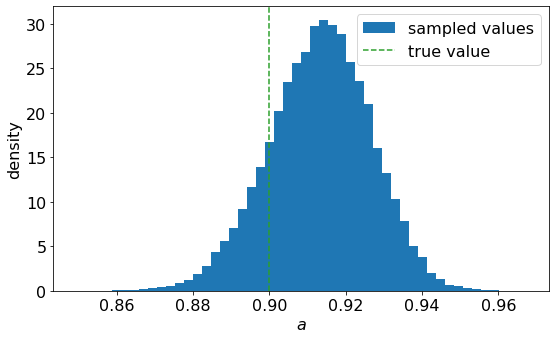

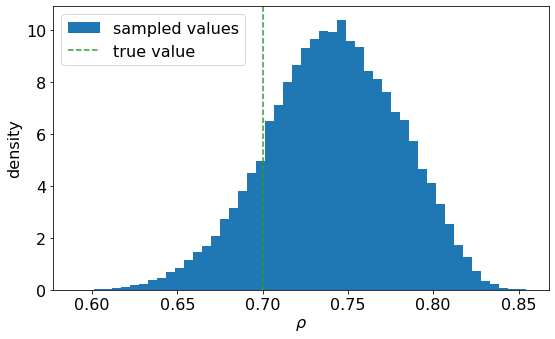

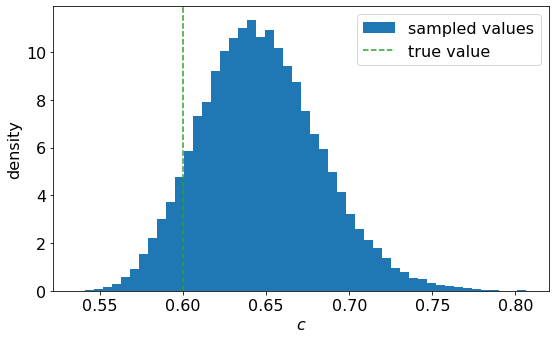

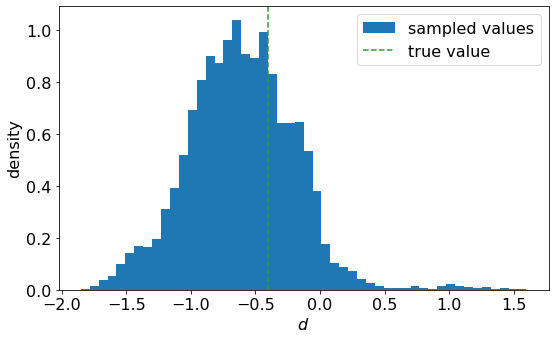

In [12]:
for pname in params_names:
    fig, ax = plt.subplots(figsize=(8,5))
    ax.hist(psamples[pname], bins=50, density=True, label=f"sampled values")
    ax.vlines(true_values[pname], 0, 1, transform=ax.get_xaxis_transform(), label="true value", linestyles='dashed', color="C2")
    ax.set_ylabel("density")
    ax.set_xlabel(pname)
    plt.legend()
    plt.tight_layout()
    plt.savefig(OUTPUTS_PATH/f"lp_{pname.strip('$')}_hist.png", dpi=150, format='png')
    plt.show()

### Convergence analysis

In [85]:
epsr = getEPSR(mcmc_ehmm_lp.samples, ehmm_burnin)

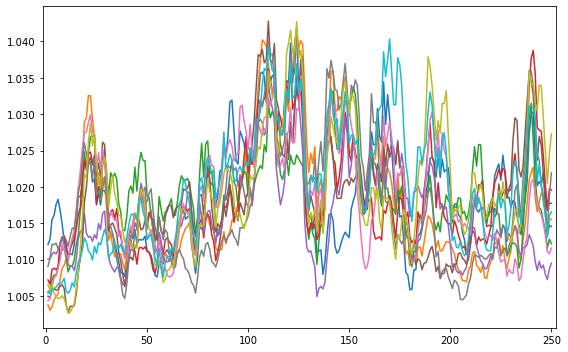

In [86]:
from matplotlib.ticker import FormatStrFormatter
fig, ax = plt.subplots(figsize=(8,5))
xs = np.array(range(1, T+1))
for i in range(n):
    ax.plot(xs, epsr[:, i])
ax.set_xmargin(0.01)
ax.locator_params(axis='y', nbins=10)
ax.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
# for i, tick in enumerate(ax.yaxis.get_ticklabels()):
#     if i % 2 != 0:
#         tick.set_visible(False) 
plt.tight_layout()
# plt.savefig(OUTPUTS_PATH/"epsr_met_lp.png", dpi=300, format='png')
plt.show();

In [87]:
epsr_params = getEPSR(mcmc_ehmm_lp.param_samples, ehmm_burnin)
pd.DataFrame({"EPSR": epsr_params}, index=params_names)

,EPSR
$a_i$,1.013900
$\rho$,1.007582
$c_i$,1.017369
$d_i$,1.041708


### Autocorrelation

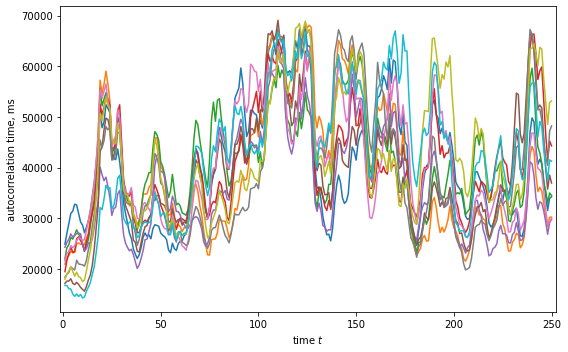

In [88]:
fig, ax = plt.subplots(figsize=(8,5))
xs = np.array(range(1, T+1))
for i in range(n):
    ax.plot(xs, taus_ehmm[i, :]*overview.loc['Time per sample, ms', 'EHMM on Poisson model 1'])
ax.set_xmargin(0.01)
ax.set_xlabel("time $t$")
ax.set_ylabel("autocorrelation time, ms")
plt.tight_layout()
# plt.savefig(OUTPUTS_PATH/"taus_ehmm_lp.png", dpi=300, format='png')
plt.show();

In [11]:
t = 125
d = 2

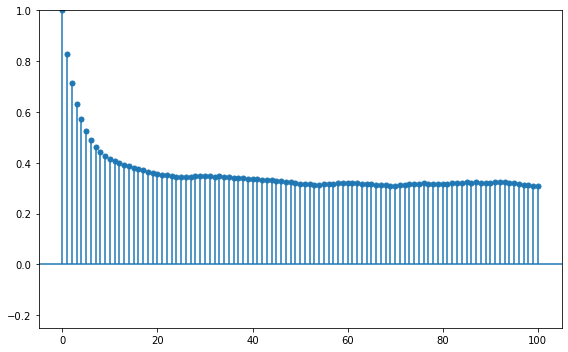

In [90]:
fig, ax = plt.subplots(figsize=(8,5))
plotACF(ac_ehmm, t, d, ax, nlags=100)
ax.set_ylim(-0.25,1)
plt.tight_layout()
# plt.savefig(OUTPUTS_PATH/f"acf_ehmm_{t}-{d}_lp.png", dpi=300, format='png')
plt.show();

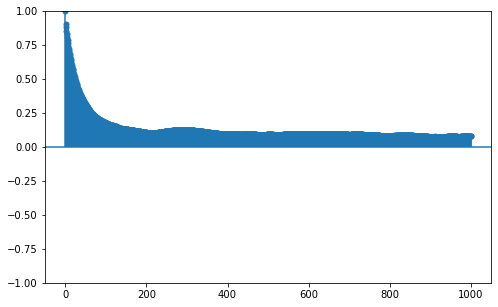

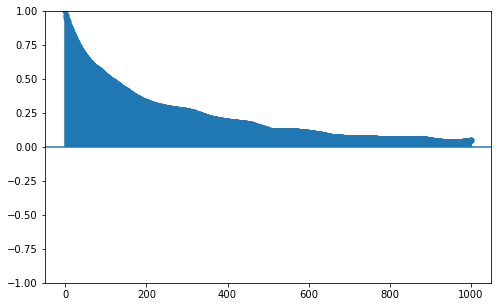

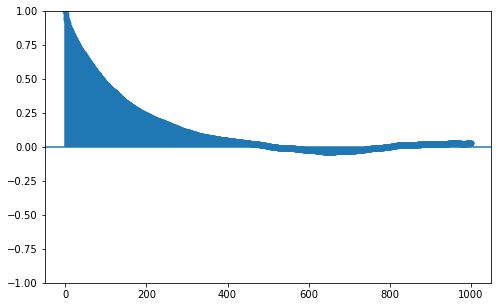

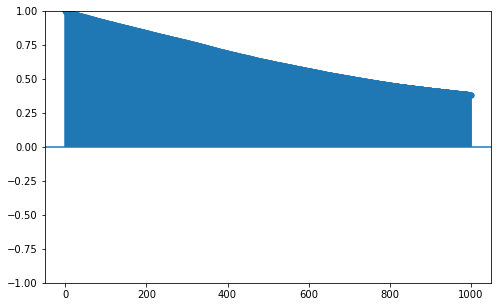

In [91]:
for idx, _ in enumerate(params_names):
    fig, ax = plt.subplots(figsize=(8, 5))
    plotACF(ac_params, 0, idx, ax, nlags=1000)

### Trace plots

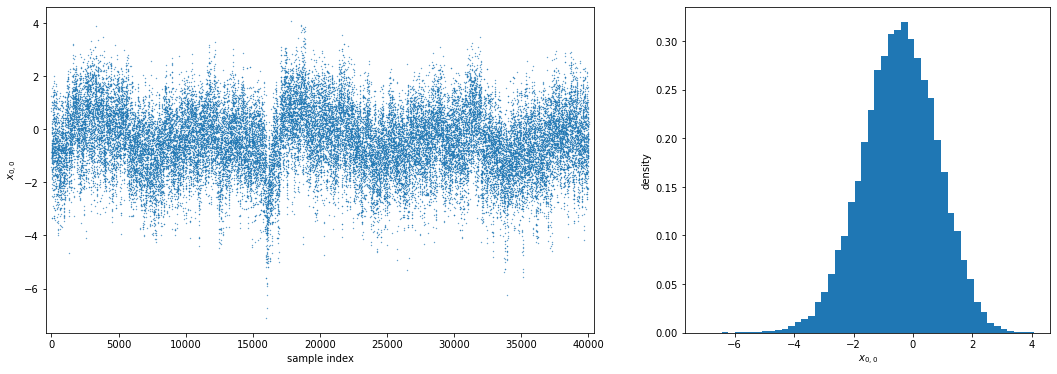

{}

In [92]:
plotTrace(ehmm_samples, t, d)

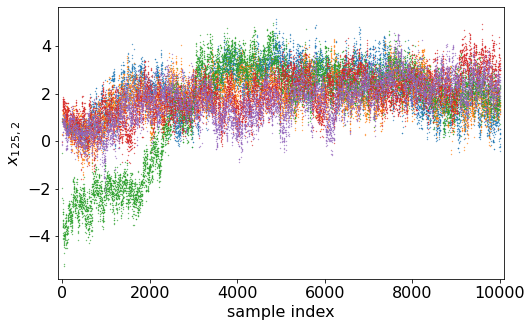

In [14]:
plotMixing(mcmc_ehmm_lp.samples, t, d, save="paraminf_lp")

In [12]:
# Compare with samplinf when params are known
comp_session_name = f"ehmm50_reverse_gauss_poiss1_5969728581958258861"
mcmc_comp = MCMCsession(comp_session_name)
mcmc_comp.loadResults()
comp_samples = mcmc_comp.getSamples(ehmm_burnin)

Loading results for seed100000...		Done
Loading results for seed10000...		Done
Loading results for seed10...		Done
Loading results for seed100...		Done
Loading results for seed1...		Done


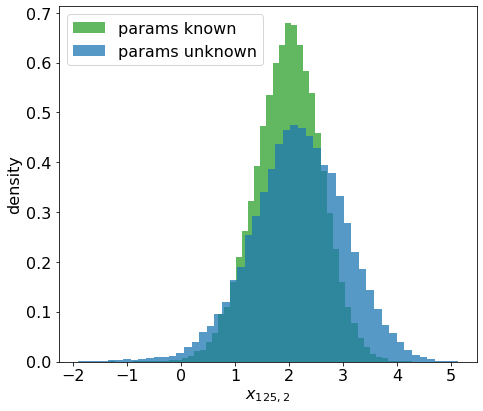

In [13]:
fig, ax = plt.subplots(figsize=(7,6))
ax.hist(comp_samples[:, t, d], bins=50, density=True, label=f"params known", alpha=0.75, color='C2')
ax.hist(ehmm_samples[:, t, d], bins=50, density=True, label=f"params unknown", alpha=0.75, color='C0')
ax.set_ylabel("density")
ax.set_xlabel(f"$x_{{{t},{d}}}$")
plt.legend(loc='upper left')
plt.tight_layout()
plt.savefig(OUTPUTS_PATH/f"paraminf_lp_comp_{t}_{d}_hist.png", dpi=150, format='png')
plt.show()

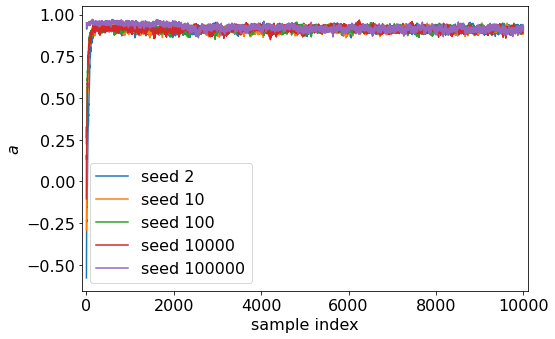

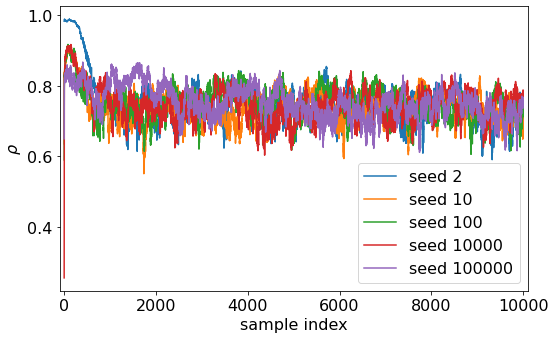

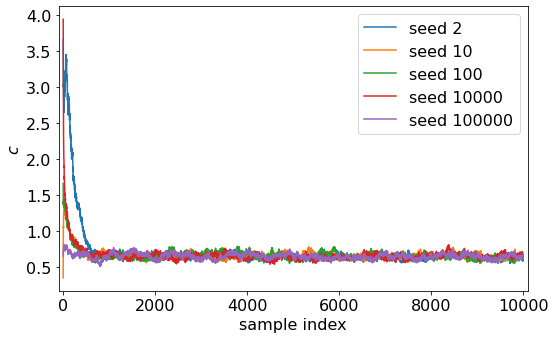

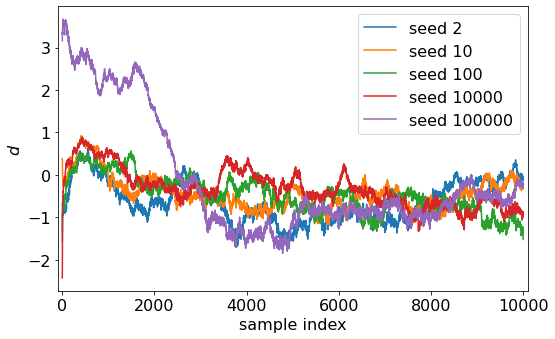

In [17]:
for idx, param_name in enumerate(params_names):
    fig, ax = plt.subplots(figsize=(8, 5))

    for seed in seeds:
        data = mcmc_ehmm_lp.getParamSamples(0, params_names, forseed=seed)
        ax.plot(data.index, data[param_name], label=f"seed {seed}")

    ax.set_xmargin(0.01)
    ax.set_ylabel(param_name)
    ax.set_xlabel("sample index")
    ax.legend()
    plt.tight_layout()
    plt.savefig(OUTPUTS_PATH / f"param_lp_plotmix_{param_name.strip('$')}.png", dpi=150, format='png')
    plt.show()

### Comparison of tuning 

In [79]:
datadict = defaultdict(dict)
for item in DATA_PATH.iterdir():
    fn = str(item).split("/")[-1]
    if fn.startswith("paramtest"):
        spec = "-".join(fn.split("_")[1:5])
        if fn.endswith('specs.h5'):
            coldict = {}
            with h5py.File(item, 'r') as f: 
                coldict[('model','A mean')] = f['model/transition/A'][4:6].mean()
                coldict[('model','A var')] = (f['model/transition/A'][5] - f['model/transition/A'][4])**2 / 12
                coldict[('model','A varscale')] = f['model/transition/A'][3]
                coldict[('model','Q mean')] = f['model/transition/Q'][4:6].mean()
                coldict[('model','Q var')] = (f['model/transition/Q'][5] - f['model/transition/Q'][4])**2 / 12
                coldict[('model','Q varscale')] = f['model/transition/Q'][3]
                coldict[('model','C mean')] = f['model/observation/C'][4]
                coldict[('model','C var')] = f['model/observation/C'][5]**2
                coldict[('model','C varscale')] = f['model/observation/C'][3]
                coldict[('model','D mean')] = f['model/observation/D'][4]
                coldict[('model','D var')] = f['model/observation/D'][5]**2
                coldict[('model','D varscale')] = f['model/observation/D'][3]
                coldict[('sampler', 'seed')] = f['simulation/seeds'][0]
                coldict[('sampler', 'npu')] = f['sampler'].attrs['num_param_updates']
                coldict[('sampler', 'scaling')] = f['simulation/scaling'][2:]
            datadict[spec].update(coldict)
        else:
            coldict = {}
            with h5py.File(item, 'r') as f:
                mcmc_name = "_".join(fn.split("_")[:-2])
                mcmc = MCMCsession(mcmc_name)
                mcmc.loadResults()
                rev = not ("noreverse" in fn)
                burnin = int(0.1 * (1 + rev) * (n_iter_ehmm + 1))
                samples = mcmc.getSamples(burnin)
                psamples = mcmc.getParamSamples(burnin, params_names)
                allpsamples = {k:v[:,np.newaxis] for k, v in mcmc.param_samples.items()}
                ac_params = getACF(allpsamples, psamples.values[:,np.newaxis], lags=1000)
                taus_params = 1 + 2 * np.sum(ac_params, axis=2)
                meantaus_params = np.mean(taus_params)
                coldict = {("params", f"{pn} mean"): pv for pn, pv in psamples.mean(axis=0).to_dict().items()}
                coldict.update({("params", f"{pn} var"): pv for pn, pv in psamples.var(axis=0).to_dict().items()})
                coldict.update({("params", f"{pn} HDR"): np.array([f"({x[0]:.2f},{x[1]:.2f})" 
                                                                   for x in getHDR(ps, bins=1000, kde=True)]).squeeze()
                                for pn, ps in psamples.items()})
                coldict.update({("params", "trm acc"): acc['trm'] for _, acc in mcmc.param_acceptances.items()})
                coldict.update({("params", "obm acc"): acc['obsm'] for _, acc in mcmc.param_acceptances.items()})
                coldict.update({("params", "mean ACT"): meantaus_params})
                coldict.update({("states","$x_{0,0}$ mean"): samples[:,0,0].mean(), ("states","$x_{0,0}$ std"): samples[:,0,0].std()})
            datadict[spec].update(coldict)
df = pd.DataFrame.from_dict(datadict)

Loading results for seed5...		Done
Loading results for seed200434834...		Done
Loading results for seed5...		Done
Loading results for seed200434834...		Done
Loading results for seed200434834...		Done
Loading results for seed200434834...		Done
Loading results for seed5...		Done
Loading results for seed200434834...		Done


In [80]:
from functools import reduce

def inHDR(hdr, val):
    hdr = [float(v) for v in hdr[1:-1].split(",")]
    lo, hi = np.min(np.abs(hdr)), np.max(np.abs(hdr))
    return lo <= abs(val) <= hi

delete = []
for en, er in df.items():
    for pn in params_names:
        hdr = er.loc[('params', f'{pn} HDR')]
        notin = True
        if hdr.size > 1:
            notin = reduce(lambda x, y: not x and not y, [inHDR(intrvl, true_values[pn]) for intrvl in hdr], notin)
        else:
            notin &= not inHDR(str(hdr), true_values[pn])
        if notin:
            print(f"Delete {en} due to {pn} out of HDR")
            delete.append(en)
            break

Delete v3a-ehmm50-noreverse-lp due to $d_i$ out of HDR


In [81]:
df.drop(delete, axis=1).sort_values(('params','mean ACT'), axis=1, ascending=True)

v3b-ehmm50-noreverse-lp v2d-ehmm50-noreverse-lp  \
params  $a_i$ mean                    0.909424                0.910641   
        $\rho$ mean                   0.738897                0.735709   
        $c_i$ mean                    0.656615                0.652032   
        $d_i$ mean                   -0.469087               -0.180382   
        $a_i$ var                     0.000184                0.000179   
        $\rho$ var                    0.001928                0.001703   
        $c_i$ var                     0.001455                0.001299   
        $d_i$ var                     0.095968                0.082833   
        $a_i$ HDR                  (0.88,0.94)             (0.88,0.94)   
        $\rho$ HDR                 (0.65,0.82)             (0.65,0.81)   
        $c_i$ HDR                  (0.58,0.73)             (0.58,0.72)   
        $d_i$ HDR                 (-1.07,0.11)            (-0.72,0.39)   
        trm acc                         133373                  203300   
        obm acc                         134870                  256167   
        mean ACT                    297.893115              316.770766   
states  $x_{0,0}$ mean               -0.647176               -1.027075   
        $x_{0,0}$ std                 1.169082                1.166143   
model   A mean                             0.0                     0.0   
        A var                         0.333333                0.333333   
        A varscale                         1.0                     1.0   
        Q mean                             0.5                     0.5   
        Q var                         0.083333                0.083333   
        Q varscale                         1.0                     4.0   
        C mean                             1.0                     1.0   
        C var                             16.0                     4.0   
        C varscale                         1.0                     1.0   
        D mean                             0.0                     0.0   
        D var                             16.0                     4.0   
        D varscale                         1.0                     1.0   
sampler seed                         200434834               200434834   
        npu                                 50                      50   
        scaling                  [0.04, 0.005]           [0.02, 0.005]   

                       v2c-ehmm50-noreverse-lp        v2e-ehmm50-noreverse-lp  \
params  $a_i$ mean                    0.910471                          0.911   
        $\rho$ mean                   0.736614                       0.737655   
        $c_i$ mean                    0.653086                       0.652203   
        $d_i$ mean                   -0.508454                      -0.460315   
        $a_i$ var                     0.000202                       0.000179   
        $\rho$ var                    0.001615                       0.001621   
        $c_i$ var                     0.001562                       0.001455   
        $d_i$ var                     0.148731                       0.234659   
        $a_i$ HDR                  (0.88,0.94)                    (0.89,0.94)   
        $\rho$ HDR                 (0.66,0.81)                    (0.66,0.82)   
        $c_i$ HDR                  (0.58,0.73)                    (0.58,0.73)   
        $d_i$ HDR                 (-1.28,0.10)  [(-1.28,-0.59), (-0.58,0.29)]   
        trm acc                         202409                          86451   
        obm acc                          58196                         150323   
        mean ACT                     447.29031                     502.397262   
states  $x_{0,0}$ mean               -0.534568                      -0.658832   
        $x_{0,0}$ std                 1.260858                       1.328449   
model   A mean                             0.0                            0.0   
        A var                         0.3